In [3]:
!gdown https://drive.google.com/uc?id=1UvHAQn7Ypzj4KonaSZJNewO1Zl_U-aHl

^C


Downloading...
From (original): https://drive.google.com/uc?id=1UvHAQn7Ypzj4KonaSZJNewO1Zl_U-aHl
From (redirected): https://drive.google.com/uc?id=1UvHAQn7Ypzj4KonaSZJNewO1Zl_U-aHl&confirm=t&uuid=e891fe56-81aa-42e9-9008-54760818652a
To: e:\học máy\phanloaiphim\INT3405-projects.zip

  0%|          | 0.00/105M [00:00<?, ?B/s]
  1%|          | 524k/105M [00:00<00:19, 5.21MB/s]
  2%|▏         | 1.57M/105M [00:00<00:13, 7.49MB/s]
  3%|▎         | 2.62M/105M [00:00<00:11, 8.71MB/s]
  4%|▎         | 3.67M/105M [00:00<00:12, 7.78MB/s]
  5%|▍         | 4.72M/105M [00:00<00:12, 8.00MB/s]
  6%|▌         | 5.77M/105M [00:00<00:11, 8.27MB/s]
  7%|▋         | 6.82M/105M [00:00<00:11, 8.46MB/s]
  8%|▊         | 7.86M/105M [00:00<00:11, 8.46MB/s]
  9%|▊         | 8.91M/105M [00:01<00:11, 8.63MB/s]
 10%|▉         | 9.96M/105M [00:01<00:10, 8.69MB/s]
 11%|█         | 11.0M/105M [00:01<00:10, 8.77MB/s]
 12%|█▏        | 12.1M/105M [00:01<00:10, 8.69MB/s]
 13%|█▎        | 13.1M/105M [00:01<00:10, 8.74MB/s]

In [1]:

!unzip INT3405-projects.zip
!cp -r 'INT3405E Final project' project
%cd project
!unzip ml1m.zip
!pip install torchmetrics


'unzip' is not recognized as an internal or external command,
operable program or batch file.


[WinError 2] The system cannot find the file specified: 'project'
e:\học máy\phanloaiphim


'cp' is not recognized as an internal or external command,
operable program or batch file.
C:\Users\thang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\magics\osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [2]:

from torchmetrics.classification import MultilabelF1Score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import models
from torchvision.models import ResNet18_Weights
from torch.utils.data import Dataset, DataLoader, random_split


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import re
import cv2
import pandas
import numpy as np

from nltk import wordpunct_tokenize


OSError: [WinError 126] The specified module could not be found. Error loading "C:\Users\thang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\lib\shm.dll" or one of its dependencies.

## Some hyper parameters

In [ ]:
BATCH_SIZE = 16
hidden_size = 128

# DATA PROCESSING
## Parse .csv into dataframe

In [ ]:
movies_train = pandas.read_csv('/content/project/content/dataset/movies_train.dat', engine='python',
                         sep='::', names=['movie_id', 'title', 'genre'], encoding='latin-1', index_col=False).set_index('movie_id')
movies_test = pandas.read_csv('/content/project/content/dataset/movies_test.dat', engine='python',
                         sep='::', names=['movie_id', 'title', 'genre'], encoding='latin-1', index_col=False).set_index('movie_id')
movies_train['genre'] = movies_train.genre.str.split('|')
movies_test['genre'] = movies_test.genre.str.split('|')

source_img_folder = '/content/project/content/dataset/ml1m-images'
movies_train['title'] = movies_train.title.str[:-6]
movies_test['title'] = movies_test.title.str[:-6]
movies_train['id'] = movies_train.index
movies_train.reset_index(inplace=True)
movies_test['id'] = movies_test.index
movies_test.reset_index(inplace=True)

movies_test['img_path'] = movies_test.apply(lambda row: os.path.join(source_img_folder, f'{row.id}.jpg'), axis = 1)
movies_train['img_path'] = movies_train.apply(lambda row: os.path.join(source_img_folder, f'{row.id}.jpg'), axis = 1)

movies_train

,movie_id,title,genre,id,img_path
0,1650,Washington Square,[Drama],1650,/content/project/content/dataset/ml1m-images/1...
1,185,"Net, The","[Sci-Fi, Thriller]",185,/content/project/content/dataset/ml1m-images/1...
2,1377,Batman Returns,"[Action, Adventure, Comedy, Crime]",1377,/content/project/content/dataset/ml1m-images/1...
3,3204,"Boys from Brazil, The",[Thriller],3204,/content/project/content/dataset/ml1m-images/3...
4,1901,Dear Jesse,[Documentary],1901,/content/project/content/dataset/ml1m-images/1...
...,...,...,...,...,...
3101,2539,Analyze This,[Comedy],2539,/content/project/content/dataset/ml1m-images/2...
3102,3038,"Face in the Crowd, A",[Drama],3038,/content/project/content/dataset/ml1m-images/3...
3103,1832,Heaven's Burning,"[Action, Drama]",1832,/content/project/content/dataset/ml1m-images/1...
3104,657,Yankee Zulu,"[Comedy, Drama]",657,/content/project/content/dataset/ml1m-images/6...


## Process data

In [ ]:
with open('/content/project/content/dataset/genres.txt', 'r') as f:
    genre_all = f.readlines()
num_classes = len(genre_all)
for i, genre in enumerate(genre_all):
  genre_all[i] = genre.strip('\n')

train_dropped = 0
test_dropped  = 0

for index, row in movies_train.iterrows():
  image_path = row['img_path']
  if not os.path.exists(image_path):
    movies_train.drop(index, inplace=True)
    train_dropped += 1

print(f"Number of data train without image: {train_dropped}")

for index, row in movies_test.iterrows():
  image_path = row['img_path']
  if not os.path.exists(image_path):
    movies_test.drop(index, inplace=True)
    test_dropped += 1

print(f"Number of data test without image: {test_dropped}")

Number of data train without image: 504
Number of data test without image: 123


## Visualize data train

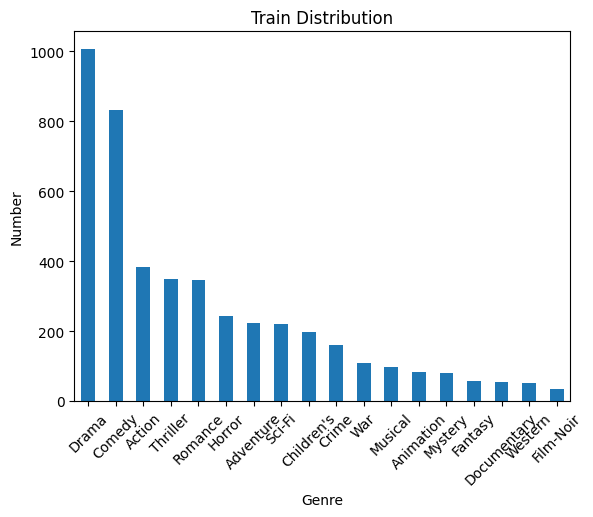

[1007, 832, 384, 349, 345, 244, 223, 219, 196, 161, 110, 96, 83, 79, 58, 53, 51, 34]


In [ ]:
df_exploded = movies_train.explode('genre')
genre_counts = df_exploded['genre'].value_counts()
genre_counts.plot(kind='bar', rot=45, xlabel='Genre', ylabel='Number', title='Train Distribution')
plt.show()
class_count = []
for count in genre_counts:
  class_count.append(count)
print(class_count)

## Visualize data test

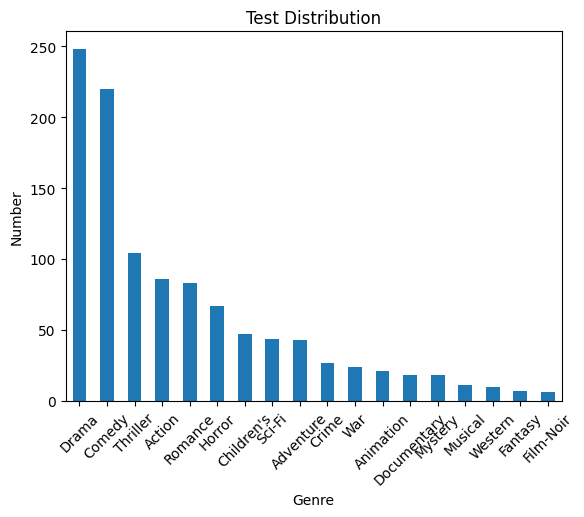

In [ ]:
df_exploded = movies_test.explode('genre')
genre_counts = df_exploded['genre'].value_counts()
genre_counts.plot(kind='bar', rot=45, xlabel='Genre', ylabel='Number', title='Test Distribution')
plt.show()

## Build Vocabulary list

In [ ]:
pad_token = '<PAD>'
unk_token = '<UNK>'
def tokenize(text):
  text = re.sub(r'[^\w\s]', '', text)
  text = text.lower()
  tokens = wordpunct_tokenize(text)
  return tokens

def create_vocab():
  df = movies_train.copy()
  arr_title = df['title'].tolist()
  vocab = set()
  for title in arr_title:
    tokens = tokenize(title)
    vocab.update(tokens)
  vocab = list(vocab)
  vocab.append(pad_token)
  vocab.append(unk_token)
  return vocab

## Dataset type

In [ ]:
"""
Abstract class of Dataset.
According to document, need these attributes: __init__, __getitem__
__len__ is optional
"""
class customDataset(Dataset):
  def __init__(self, data):
    self.data = data
    self.data['title_tokens'] = [tokenize(x) for x in self.data.title]
    vocab = create_vocab()
    self.token2idx = {token : idx for idx, token in enumerate(vocab)}
    #print(self.token2idx)
    MAX_LENGTH = 7
    vectors = []
    for title_tokens in self.data.title_tokens.tolist():
      if len(title_tokens) < MAX_LENGTH:
        num_pad = MAX_LENGTH - len(title_tokens)
        for idx in range(num_pad):
          title_tokens.append(pad_token)
      else:
        title_tokens = title_tokens[:MAX_LENGTH]
      title_vectors = []
      for word in title_tokens:
        binary_vector = np.zeros(len(vocab))
        if word in vocab:
          binary_vector[self.token2idx[word]] = 1
        else:
          binary_vector[self.token2idx[unk_token]] = 1
        title_vectors.append(binary_vector)

      vectors.append(np.array(title_vectors))
    self.data['vectors'] = vectors
    with open('/content/project/content/dataset/genres.txt', 'r') as f:
      genres = f.readlines()
      genres = [genre.strip('\n') for genre in genres]
    self.genre2idx = {genre : idx for idx, genre in enumerate(genres)}
  def __getitem__(self, index):
    title = self.data.iloc[index].title
    img_path = self.data.iloc[index].img_path
    genre = self.data.iloc[index].genre

    title_vector = self.data.iloc[index].vectors
    title_tensor = torch.from_numpy(title_vector).float()

    if os.path.exists(img_path):
      img = cv2.imread(img_path)
    else:
      img = np.random.rand(256,256,3)
    img = cv2.resize(img, (256,256))
    img_tensor = torch.from_numpy(img.transpose(2,0,1)).float()
    genre_vector = np.zeros(len(self.genre2idx))
    for g in genre:
      genre_vector[self.genre2idx[g]] = 1
    genre_tensor = torch.from_numpy(genre_vector).float()

    return title_tensor, img_tensor, genre_tensor

  def __len__(self):
    return len(self.data)


In [ ]:
training_set = customDataset(data = movies_train)
testing_set = customDataset(data = movies_test)
len(testing_set)


654

## Split data into train and validation

In [ ]:
# Random split validation set, training set and initialize testing set
val_size = int(0.2 * len(training_set))
train_size = len(training_set) - val_size
train_set, val_set = random_split(training_set, [train_size, val_size])
train_dataloader = DataLoader(train_set, batch_size = BATCH_SIZE)
val_dataloader = DataLoader(val_set, batch_size = BATCH_SIZE)
test_dataloader = DataLoader(testing_set, batch_size = BATCH_SIZE)
len(test_dataloader)

41

In [ ]:
for title_tensor, img_tensor, genre_tensor in train_dataloader:
  print(title_tensor.shape, img_tensor.shape, genre_tensor.shape)
  break
for title_tensor, img_tensor, genre_tensor in test_dataloader:
  print(title_tensor.shape, img_tensor.shape, genre_tensor.shape)
  break

torch.Size([16, 7, 3321]) torch.Size([16, 3, 256, 256]) torch.Size([16, 18])
torch.Size([16, 7, 3321]) torch.Size([16, 3, 256, 256]) torch.Size([16, 18])


In [ ]:
# Init vocaburary list and double check
vocab = create_vocab()
len_vocab = len(vocab)
len_vocab

3321

# FIRST APPROACH
## Base model with conv and maxpool layer for image
## Only linear layer for text

In [ ]:
######################################
############DEPRECATED################
######################################
# Do not use, stay here for report
class deprecated_model(nn.Module):
  def __init__(self):
    super(deprecated_model, self).__init__()
    self.hidden_size = hidden_size

    # img
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
    self.maxpool = nn.MaxPool2d(kernel_size=4, stride=4)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(32)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(32 * 64 * 64, hidden_size)

    # text
    self.fc2 = nn.Linear(7*len_vocab, hidden_size)
    self.fc3 = nn.Linear(hidden_size*2, num_classes)

  def forward(self, title_tensor, img_tensor):
    text_feat = F.relu(self.fc2(self.flatten(title_tensor)))
    img_feat = self.conv1(img_tensor)
    img_feat = F.relu(self.maxpool(img_feat))
    img_feat = self.conv2(img_feat)
    img_feat = F.relu(self.fc1(self.flatten(img_feat)))

    out = self.fc3(torch.cat([text_feat, img_feat], dim=1))
    return out

# SECOND APPROACH
## Using ResNet18 hopefully to improve quality

In [ ]:
# TODO: Try better base model i guess
"""
Abstract class of nn.Module.
Using pretrained Resnet18 for image process.
Number of output neurons = number of classes
"""
class BaseModel(nn.Module):
  def __init__(self):
    super(BaseModel, self).__init__()
    self.hidden_size = hidden_size

    # img
    resnet18 = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    self.resnet18_features = nn.Sequential(*list(resnet18.children())[:-1])
    self.bn2 = nn.BatchNorm2d(512)

    # text
    self.fc1 = nn.Linear(7*len_vocab, hidden_size)
    self.flatten = nn.Flatten()

    # combine
    self.fc2 = nn.Linear(hidden_size + 512, hidden_size)

    # out
    self.fc3 = nn.Linear(hidden_size, num_classes)

  def forward(self, title_tensor, img_tensor):

    # Text feature
    text_feat = F.relu(self.fc1(self.flatten(title_tensor)))

    # Img feature
    img_feat = self.resnet18_features(img_tensor)
    img_feat = F.relu(self.bn2(img_feat))
    img_feat = img_feat.view(img_feat.size(0), -1)

    # Combine feature
    combined_feat = torch.cat([text_feat, img_feat], dim=1)
    combined_feat = F.relu(self.fc2(combined_feat))

    # Out feature
    out = self.fc3(combined_feat)
    return out


# THIRD APPROACH
## Trying to modify weight to solve imbalance data problem

In [ ]:
class_weight = 1.0 / torch.tensor(class_count, dtype=torch.float)
class_weight /= class_weight.sum()
class_weight

tensor([0.0060, 0.0073, 0.0158, 0.0174, 0.0176, 0.0249, 0.0273, 0.0278, 0.0310,
        0.0378, 0.0553, 0.0634, 0.0733, 0.0770, 0.1049, 0.1148, 0.1193, 0.1789])

In [ ]:
class_weight[0] *= 10
class_weight[1] *= 10
class_weight /= class_weight.sum()
class_weight

tensor([0.0539, 0.0653, 0.0141, 0.0156, 0.0157, 0.0223, 0.0244, 0.0248, 0.0277,
        0.0337, 0.0494, 0.0566, 0.0654, 0.0687, 0.0936, 0.1025, 0.1065, 0.1597])

# Multiple attemps on tuning parameters, loss function and weight
## Implementation attempt of dropout and early stop

In [ ]:
# TODO: Implementation of dropout and weight save (especially best weight save)
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, dropout_prob, early_stopping_patience):
  """
  Train function
  ---------
  Params:
  model:  abstract class of nn.Module
          trained model
  train_loader: Dataloader
                for train set
  val_loader: Dataloader
              for val set
  criterion:  loss function
  num_epochs: int
              number of epochs to train
  dropout_prob: int | None
  early_stopping_patience:  int | None
                            How many time of no improvement on validation set to stop
  --------
  """
  best_val_loss = float('inf')
  patience_counter = 0
  train_losses = []
  val_losses = []
  for epoch in range(num_epochs):
    # Train process implementation
    model.train()
    total_loss = 0.0
    for batch_idx, (title_tensor, img_tensor, genre_tensor) in enumerate(train_loader):
      title_tensor, img_tensor, genre_tensor = title_tensor.to(device), img_tensor.to(device), genre_tensor.to(device)

      optimizer.zero_grad()

      outputs = model(title_tensor, img_tensor)
      loss = criterion(outputs, genre_tensor)

      loss.backward()
      optimizer.step()

      total_loss += loss.item()
      if batch_idx % 100 == 99:
        print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}, Training Loss: {total_loss / 100:.4f}")
        total_loss = 0.0
    train_losses.append(total_loss / len(train_loader))
    # Validation process implementation
    model.eval()
    val_loss = 0.0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
      for val_title_tensor, val_img_tensor, val_genre_tensor in val_loader:
        val_title_tensor, val_img_tensor, val_genre_tensor = val_title_tensor.to(device), val_img_tensor.to(device), val_genre_tensor.to(device)
        val_outputs = model(val_title_tensor, val_img_tensor)
        val_loss += criterion(val_outputs, val_genre_tensor).item()
        all_predictions.extend((val_outputs > 0.5).float().cpu().numpy())
        all_labels.extend(val_genre_tensor.cpu().numpy())
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f"Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}")

    all_predictions = torch.tensor(all_predictions).to(device)
    all_labels = torch.tensor(all_labels).to(device)
    f1_val = f1(all_predictions, all_labels)
    print(f"Epoch {epoch + 1}, F1 Score (Validation): {f1_val:.4f}")

    # Early stopping implementation
    if early_stopping_patience is not None:
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
      else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
          print(f"Early stopped. No improvement for {early_stopping_patience} epochs.")
          break
  epochs = np.arange(1, num_epochs + 1)
  plt.plot(epochs, train_losses, label='Training Loss')
  plt.plot(epochs, val_losses, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Training and Validation Losses')
  plt.show()
  print("Done")

model = BaseModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Init F1
N, C = genre_tensor.shape
f1_all = 0
f1 = MultilabelF1Score(num_labels=C, threshold=0.5, average='macro')
f1 = f1.to(device)

# Call the train method with neccessary variables
learning_rate = 0.001
dropout_prob=None
early_stopping_patience=None
num_epochs=20
criterion = nn.BCEWithLogitsLoss()
criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, dropout_prob=dropout_prob, early_stopping_patience=early_stopping_patience)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\thang/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


Epoch 1, Batch 100, Training Loss: 0.3045
Epoch 1, Validation Loss: 0.2668
Epoch 1, F1 Score (Validation): 0.0080


C:\Users\thang\AppData\Local\Temp\ipykernel_2860\1970268646.py:61: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  all_predictions = torch.tensor(all_predictions).to(device)


KeyboardInterrupt: 

In [ ]:
# Double check the dimensions of tensors, useful when coding
for items in test_dataloader:
  title_tensor, img_tensor, genre_tensor = items
  print("Title Tensor Sizes:", title_tensor.size())
  print("Image Tensor Sizes:", img_tensor.size())
  print("Genre Tensor Sizes:", genre_tensor.size())
  break

Title Tensor Sizes: torch.Size([16, 7, 3321])
Image Tensor Sizes: torch.Size([16, 3, 256, 256])
Genre Tensor Sizes: torch.Size([16, 18])


In [ ]:
N, C = genre_tensor.shape

auroc_all = 0
f1_all = 0
f1 = MultilabelF1Score(num_labels=C, threshold=0.3, average='weighted')
f1 = f1.to(device)
model.eval()
for title_tensor, img_tensor, genre_tensor in test_dataloader:
  title_tensor = title_tensor.to(device)
  img_tensor = img_tensor.to(device)
  genre_tensor = genre_tensor.to(device)

  out = model(title_tensor, img_tensor)
  f1_batch = f1(out, genre_tensor)
  f1_all += f1_batch

print('F1: ', f1_all/len(test_dataloader))

F1:  tensor(0.2150)


# Predict base on thresholding
## The result is not good

In [ ]:
def predict(model, title_tensor, img_tensor):
  """
  Predict classes base on thresholding.
  ---------
  Params:
  model:  abstract class of nn.Module
          trained model
  title_tensor:   torch.Tensor
                  Tensor for text data, here is the title
  img_tensor: torch.Tensor
              Tensor for image data, here is the cover picture
  --------
  Output:
  Array of C elements after thresholded, with C is number of classes
  """
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  model.eval()

  with torch.no_grad():
    title_tensor, img_tensor = title_tensor.to(device), img_tensor.to(device)
    outputs = model(title_tensor, img_tensor)
    predicted_probs = torch.sigmoid(outputs)
    predicted_labels = (predicted_probs > 0.5).float()

  return predicted_labels.cpu().numpy()

for test_idx, (title_tensor, img_tensor, genre_tensor) in enumerate(test_dataloader):
  titles = testing_set.data['title'].tolist()
  img_paths = testing_set.data['img_path'].tolist()
  genres =  testing_set.data['genre'].tolist()
  target_title_tensor = title_tensor
  target_img_tensor = img_tensor
  predictions = predict(model, target_title_tensor, target_img_tensor)
  print(len(predictions))
  for i in range(title_tensor.size(0)):
    index = test_idx * title_tensor.size(0) + i
    title = titles[index]
    genre = genres[index]
    predicted_categories = [genre for genre, pred in zip(genre_all, predictions[i]) if pred == 1]
    predicted_categories_str = ','.join(predicted_categories)
    print(f"Ex. {index}: {title} - {genre} - Predicted: {predicted_categories_str}")

16
Ex. 544: Indiana Jones and the Last Crusade  - ['Action', 'Adventure'] - Predicted: 
Ex. 545: Lawnmower Man, The  - ['Action', 'Sci-Fi', 'Thriller'] - Predicted: 
Ex. 546: Nothing to Lose  - ['Drama'] - Predicted: 
Ex. 547: Shooter, The  - ['Action'] - Predicted: 
Ex. 548: Apple Dumpling Gang Rides Again, The  - ["Children's", 'Comedy', 'Western'] - Predicted: 
Ex. 549: Vacation  - ['Comedy'] - Predicted: 
Ex. 550: Vagabond (Sans toit ni loi)  - ['Drama'] - Predicted: 
Ex. 551: Don't Look in the Basement!  - ['Horror'] - Predicted: 
Ex. 552: Even Cowgirls Get the Blues  - ['Comedy', 'Romance'] - Predicted: 
Ex. 553: Judge Dredd  - ['Action', 'Adventure', 'Sci-Fi'] - Predicted: 
Ex. 554: Dead Man on Campus  - ['Comedy'] - Predicted: 
Ex. 555: Inventing the Abbotts  - ['Drama', 'Romance'] - Predicted: 
Ex. 556: Disturbing Behavior  - ['Horror', 'Thriller'] - Predicted: 
Ex. 557: Love & Sex  - ['Comedy', 'Romance'] - Predicted: 
Ex. 558: Lost in Space  - ['Action', 'Sci-Fi', 'Thriller'

# topk approach
## Used on both predict and evaluation via map@k

In [ ]:
topk = 3
def percent_classes(model, title_tensor, img_tensor, topk=3):
  """
  Predict the top k classes and their corresponding percentage.
  ---------
  Params:
  model:  abstract class of nn.Module
          trained model
  title_tensor:   torch.Tensor
                  Tensor for text data, here is the title
  img_tensor: torch.Tensor
              Tensor for image data, here is the cover picture
  topk: int
        the top number of classes with highest predict percentage
  ---------
  Output:
  Tuple of Ndarray of top classes and their probabilities.
  """
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  model.eval()

  with torch.no_grad():
    title_tensor, img_tensor = title_tensor.to(device), img_tensor.to(device)
    outputs = model(title_tensor, img_tensor)
    predicted_probs = torch.sigmoid(outputs)
    top_probs, top_classes = torch.topk(predicted_probs, topk, dim=1)
    top_probs = top_probs.cpu().numpy()
    top_classes = top_classes.cpu().numpy()

  return top_probs, top_classes

for test_idx, (title_tensor, img_tensor, genre_tensor) in enumerate(test_dataloader):
  titles = testing_set.data['title'].tolist()
  img_paths = testing_set.data['img_path'].tolist()
  genres = testing_set.data['genre'].tolist()
  target_title_tensor = title_tensor
  target_img_tensor = img_tensor
  top_probs, top_classes = percent_classes(model, target_title_tensor, target_img_tensor, topk=topk)
  for i in range(title_tensor.size(0)):
    index = test_idx * title_tensor.size(0) + i
    title = titles[index]
    genre = genres[index]
    predicted_categories = [genre_all[class_idx] for class_idx in top_classes[i]]
    predicted_probabilities = [f"{prob * 100:.2f}%" for prob in top_probs[i]]
    prediction = []
    for idx in range(topk):
      prediction.append(predicted_categories[idx] + "-" + predicted_probabilities[idx])
    print(f"Ex. {index}: {title} - {genre} - Predicted: {prediction} ")


Ex. 0: Great Muppet Caper, The  - ["Children's", 'Comedy'] - Predicted: ["Children's-17.41%", 'Drama-15.99%', 'Comedy-13.22%'] 
Ex. 1: Doctor Zhivago  - ['Drama', 'Romance', 'War'] - Predicted: ['Drama-9.40%', 'Adventure-3.50%', "Children's-2.91%"] 
Ex. 2: Frankenstein Meets the Wolf Man  - ['Horror'] - Predicted: ['Comedy-24.94%', 'Drama-12.17%', "Children's-5.99%"] 
Ex. 3: For Your Eyes Only  - ['Action'] - Predicted: ['Comedy-32.58%', "Children's-28.42%", 'Drama-27.34%'] 
Ex. 4: Mirror, The (Zerkalo)  - ['Drama'] - Predicted: ['Drama-42.39%', 'Action-30.89%', 'Thriller-25.04%'] 
Ex. 5: Wolf  - ['Drama', 'Horror'] - Predicted: ['Action-43.58%', 'Drama-35.59%', 'Thriller-24.67%'] 
Ex. 6: All Quiet on the Western Front  - ['War'] - Predicted: ['Action-51.19%', 'Drama-38.28%', 'Thriller-30.65%'] 
Ex. 7: Nelly & Monsieur Arnaud  - ['Drama'] - Predicted: ['Drama-28.48%', 'Adventure-14.18%', "Children's-11.34%"] 
Ex. 8: Freedom for Us (Ã nous la libertÃ© )  - ['Comedy'] - Predicted: ['Dra

In [ ]:
def apk(actual : list | int, predicted: list, k: int):
  """
  Computes the average precision at k.
  This function computes the average prescision at k between two lists of
  items.
  Parameters
  ----------
  actual : list
            A list of elements that are to be predicted (order doesn't matter)
  predicted : list
              A list of predicted elements (order does matter)
  k : int, optional
      The maximum number of predicted elements
  Returns
  -------
  score : double
          The average precision at k over the input lists
  """
  if not actual:
    return 0.0

  if len(predicted)>k:
    predicted = predicted[:k]

  score = 0.0
  num_hits = 0.0
  a = actual if type(actual) is list else [actual]
  for i,p in enumerate(predicted):
    if p in a and p not in predicted[:i]:
      num_hits += 1.0
      score += num_hits / (i+1.0)

  return score / min(len(a), k)

def mapk(actual: list | int, predicted: list, k: int):
  """
  Computes the mean average precision at k.
  This function computes the mean average prescision at k between two lists
  of lists of items.
  Parameters
  ----------
  actual : list
            A list of lists of elements that are to be predicted
            (order doesn't matter in the lists)
  predicted : list
              A list of lists of predicted elements
              (order matters in the lists)
  k : int, optional
      The maximum number of predicted elements
  Returns
  -------
  score : double
          The mean average precision at k over the input lists
  """
  if isinstance(actual, int):
    actual = actual.tolist()
  return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

for test_idx, (title_tensor, img_tensor, genre_tensor) in enumerate(test_dataloader):
    titles = testing_set.data['title'].tolist()
    img_paths = testing_set.data['img_path'].tolist()
    genres = testing_set.data['genre'].tolist()
    target_title_tensor = title_tensor
    target_img_tensor = img_tensor
    top_probs, top_classes = percent_classes(model, target_title_tensor, target_img_tensor, topk=topk)
    actuals = [genre_tensor[i].nonzero().squeeze().tolist() for i in range(genre_tensor.size(0))]
    print(f"Batch {test_idx}: {mapk(actuals,top_classes,topk):.4f}")


Batch 0: 0.4479
Batch 1: 0.5312
Batch 2: 0.5469
Batch 3: 0.3906
Batch 4: 0.5122
Batch 5: 0.6771
Batch 6: 0.2986
Batch 7: 0.3438
Batch 8: 0.5260
Batch 9: 0.5035
Batch 10: 0.3958
Batch 11: 0.4687
Batch 12: 0.3854
Batch 13: 0.4809
Batch 14: 0.4688
Batch 15: 0.5417
Batch 16: 0.4375
Batch 17: 0.5556
Batch 18: 0.5677
Batch 19: 0.4392
Batch 20: 0.4410
Batch 21: 0.5226
Batch 22: 0.4896
Batch 23: 0.5156
Batch 24: 0.5365
Batch 25: 0.4844
Batch 26: 0.4844
Batch 27: 0.5226
Batch 28: 0.4531
Batch 29: 0.6979
Batch 30: 0.6562
Batch 31: 0.4896
Batch 32: 0.5382
Batch 33: 0.4271
Batch 34: 0.4566
Batch 35: 0.6128
Batch 36: 0.4844
Batch 37: 0.6580
Batch 38: 0.4514
Batch 39: 0.4844
Batch 40: 0.6151
